<a href="https://colab.research.google.com/github/fabiodr/colabs/blob/main/ChainOfAgents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chain-of-Agents (CoA) Implementation
https://openreview.net/pdf?id=LuCLf4BJsr

A framework that enables LLMs to process long contexts through multi-agent collaboration.
The approach works in two stages:
1. Worker agents sequentially process different chunks of text, passing information forward
2. A manager agent synthesizes the workers' contributions into a final output

Key features:
- Processes entire input through interleaved reading and reasoning
- Each agent handles manageable context length to maintain focus
- No additional training required
- Works for tasks like QA, summarization, and code completion
- Improves performance by up to 10% over traditional approaches

**Understanding Chain of Agents**

Chain of Agents addresses a fundamental challenge in working with LLMs - processing long contexts effectively. The approach is remarkably intuitive: rather than trying to feed an entire long document into a single LLM call, it breaks the task into manageable chunks processed by a chain of "worker" agents, with their insights synthesized by a "manager" agent.

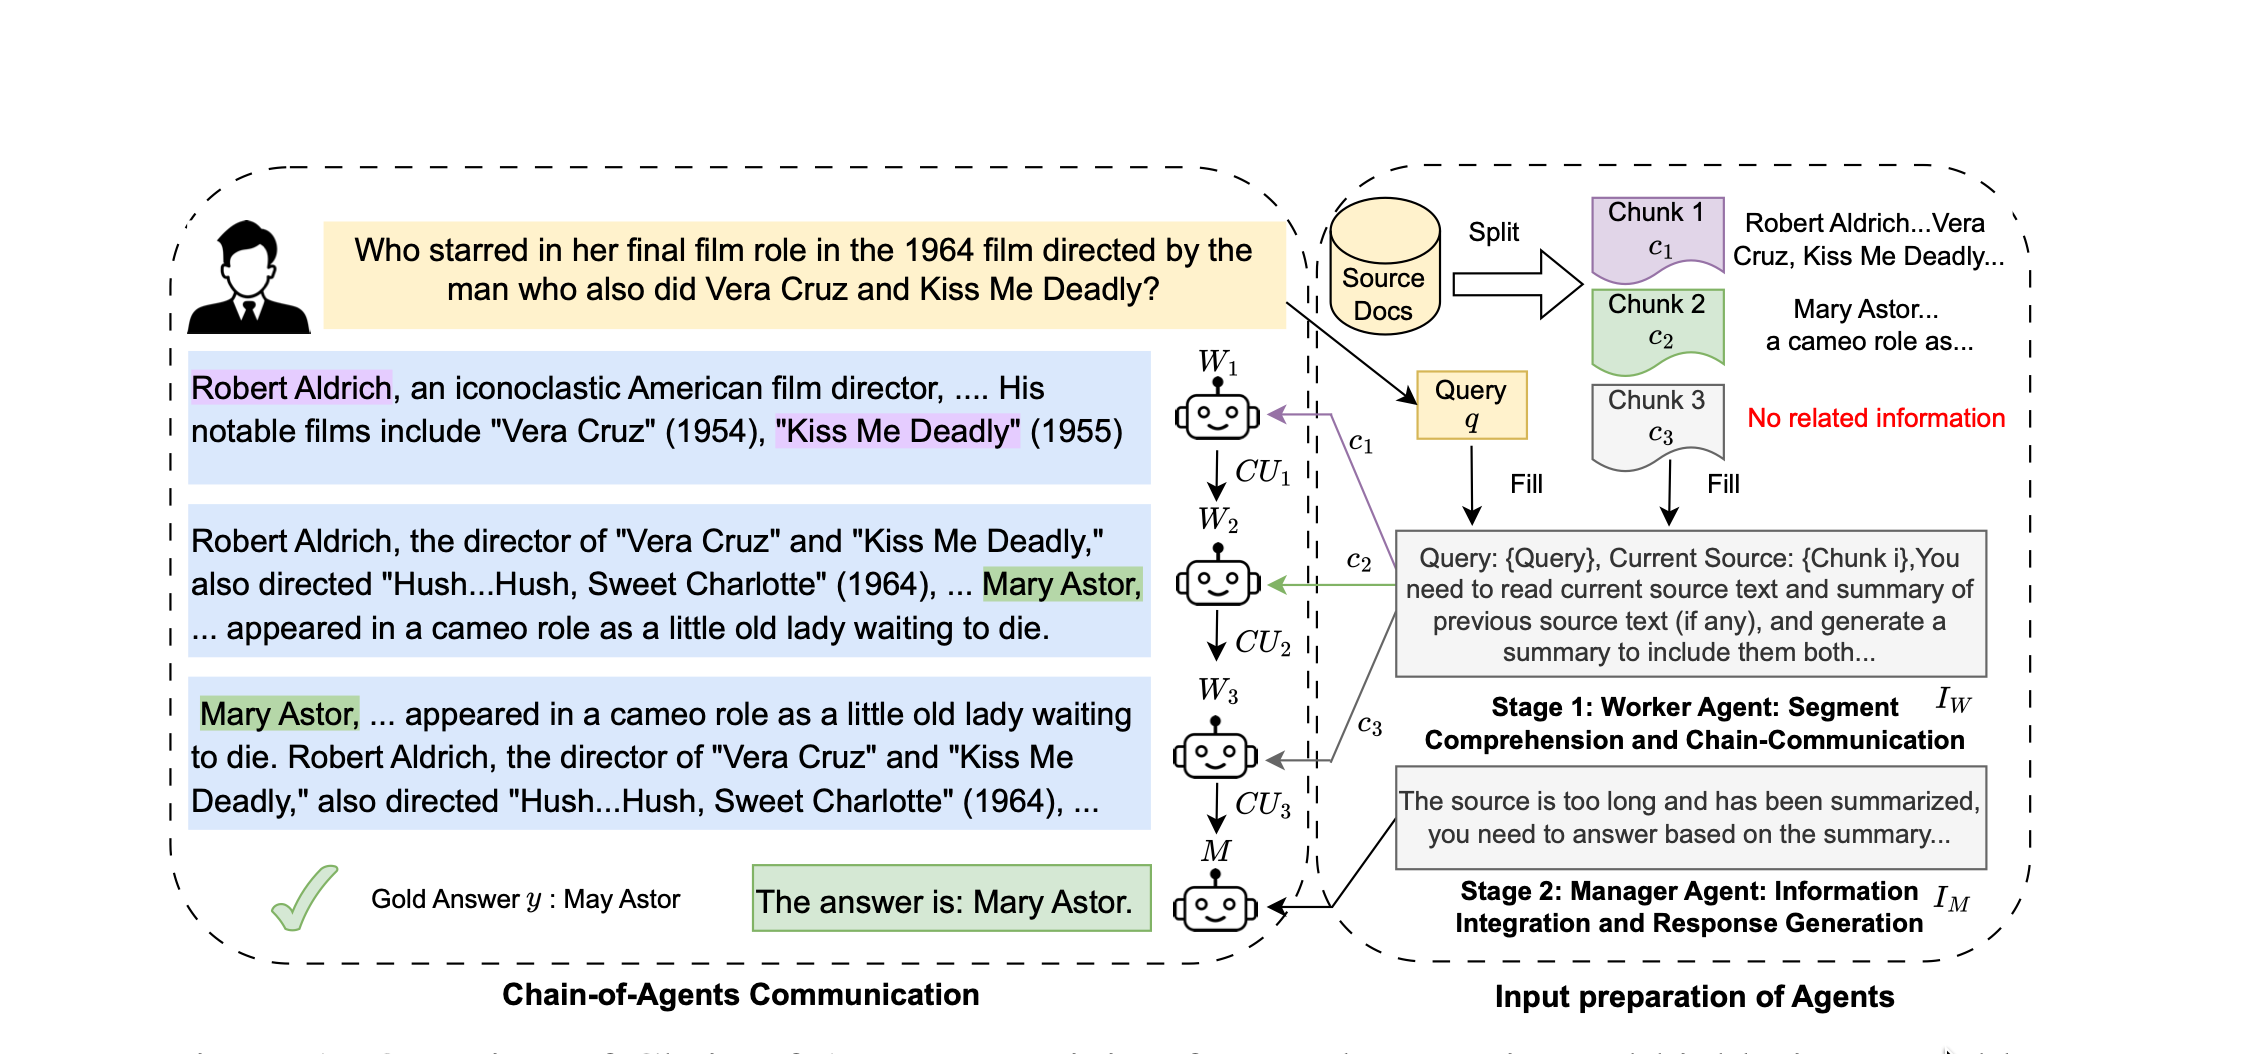


What makes CoA particularly interesting is its sequential communication pattern. Each worker agent processes its chunk of text while considering the insights from previous workers, building up a comprehensive understanding of the content. This approach mirrors how humans process long documents - reading and reasoning in segments while maintaining context.

Original paper from Google Cloud AI can be found here:
https://openreview.net/pdf?id=LuCLf4BJsr

In [ ]:
!pip install dspy

In [ ]:
import dspy
import os
from typing import Iterable
from google.colab import userdata

**DSPY Implementation: Breaking It Down**

The implementation in DSPY (https://dspy.ai) is surprisingly clean and follows the paper's architecture closely. Let's examine the key components

**1. TextNode structure.**

This simple class represents chunks of our input text, making it easy to track and process segments of long documents.

In [ ]:
class TextNode:
    def __init__(self, id: str, text: str):
        self.id = id
        self.text = text

    def __str__(self):
        return f"TextNode(id={self.id}, text={self.text})"

    def __repr__(self):
        return self.__str__()

**2. Worker Agent Implementation**
The worker agent's role is expressed through DSPY's Signature and Module system, which lets us specify the expected inputs and outputs as structured fields rather than through prompt engineering.

In [ ]:
class WorkerAgentSignature(dspy.Signature):
    """You need to read current source text and summary of previous source text (if any) and generate asummary to include them both.
    Later, this summary will be used for other agents to address the Query, if any.
    So please write the summary that can include the evidence for answering the Query."""

    query: str = dspy.InputField(desc="Query to answer")
    source_text: str = dspy.InputField(desc="Current source text")
    previous_summary: str = dspy.InputField(desc="Summary of previous source text (if any)")
    summary: str = dspy.OutputField(desc="Summary to include the evidence for answering the Query")

class WorkerAgent(dspy.Module):
    def __init__(self, lm: dspy.LM):
        super().__init__()
        self.lm = lm
        self.worker_agent = dspy.ChainOfThought(WorkerAgentSignature)

    def forward(self, query: str, source_text: str, previous_summary: str = "") -> dspy.Prediction:
        with dspy.context(lm=self.lm):
            return self.worker_agent(query=query, source_text=source_text, previous_summary=previous_summary)

What makes this implementation  effective is how it leverages DSPY's abstractions:
The Signature class clearly defines what information flows in and out of each worker agent through typed fields with descriptions, making the interface explicit and maintainable.
Instead of crafting prompt strings, we express the agent's behavior through the Signature class and its docstring. DSPY handles the conversion of this structured definition into appropriate prompts.
By using dspy.ChainOfThought module, we leverage DSPY's pre-built abstraction for Chain-of-Thought prompting. Instead of manually crafting prompts with "Let's solve this step by step" or similar CoT patterns, DSPY handles this prompting strategy internally. This is a perfect example of DSPY's philosophy - rather than writing prompt strings, we simply select an appropriate module (ChainOfThought) that implements the prompt pattern we want.

**3. ManagerAgent Design**
The manager agent synthesizes the accumulated knowledge into a final answer, showcasing how DSPY modules let us express flow behavior as standard structured code .

In [ ]:
class ManagerAgentSignature(dspy.Signature):
    """The following are given passages. However, the source text is too long and has been summarized.
    You need to answer query based on the summary"""

    query: str = dspy.InputField(desc="Query to answer")
    summary: str = dspy.InputField(desc="Summary of the source text")
    answer: str = dspy.OutputField(desc="Answer to the Query")

class ManagerAgent(dspy.Module):
    def __init__(self, lm: dspy.LM):
        super().__init__()
        self.lm = lm
        self.manager_agent = dspy.ChainOfThought(ManagerAgentSignature)

    def forward(self, query: str, summary: str) -> dspy.Prediction:
        with dspy.context(lm=self.lm):
            return self.manager_agent(query=query, summary=summary)

The ManagerAgentSignature defines the expected inputs (query and summary) and output (answer) behavior, while DSPY handles the underlying prompt generation and output parsing, allowing us to focus on the logical flow of information rather than prompt crafting.

**The Power of Integration**

What makes this implementation particularly effective is how DSPY's module system lets us express the Chain of Agents architecture as composable components.


In [ ]:
class ChainOfAgents(dspy.Module):
    def __init__(self, worker_lm: dspy.LM, manager_lm: dspy.LM):
        super().__init__()
        self.worker_lm = worker_lm
        self.manager_lm = manager_lm
        self.worker_agent = WorkerAgent(worker_lm)
        self.manager_agent = ManagerAgent(manager_lm)

    def forward(self, query: str, text_nodes: Iterable[TextNode]) -> dspy.Prediction:
        # Process nodes one by one, building up the summary incrementally
        current_summary = ""
        for node in text_nodes:
            worker_result = self.worker_agent(
                query=query,
                source_text=node.text,
                previous_summary=current_summary
            )
            current_summary = worker_result.summary

        # Once all nodes are processed, use the manager agent to generate final answer
        return self.manager_agent(query=query, summary=current_summary)

**Run IT**

1. Open the Secrets Panel: Go to the left sidebar in Colab and click on the key icon to open the "Secrets" panel.
2. Add a Secret: Click on "Add a new secret".
3. Give your secret a name LLM_API_KEY
4. Turn Switch "Allow Notebook Access"
5. Close the "Secrets" panel.

In [ ]:
api_key = userdata.get('LLM_API_KEY')
model_name = "gemini/gemini-1.5-flash"

worker_lm = dspy.LM(model=model_name, api_key=api_key, cache=False)
manager_lm = dspy.LM(model=model_name, api_key=api_key, cache=False)

# Create chain of agents
chain = ChainOfAgents(worker_lm=worker_lm, manager_lm=manager_lm)

# Example text nodes
# in real world scenario, the nodes are chunks of text extracted from any source texts or documents
nodes = [
    TextNode("1", "The cat is sitting on the mat. It looks very comfortable."),
    TextNode("2", "The mat is blue and made of soft material."),
    TextNode("3", "There's also a dog nearby watching the cat carefully.")
]

# Example query
query = "What is the scene about and what colors are mentioned?"

# Get the answer
result = chain(query=query, text_nodes=nodes)
print(f"Query: {query}")
print(f"Answer: {result.answer}")

Query: What is the scene about and what colors are mentioned?
Answer: The scene is about a cat sitting on a blue mat, with a dog watching. The only color mentioned is blue.


The real power of DSPY isn't just in simplifying LLM interactions - it's in helping us think about AI systems as structured, composable components rather than collections of prompts. As we continue building more complex AI systems, this shift from prompt engineering to system design becomes increasingly valuable.

**What's Left Outside**

1. DSPY provides sophisticated optimizers that can tune both prompts and modules automatically
2. DSPY provides classes help you measure performance of your modules
Have fun with DSPY!
https://dspy.ai
